In [1]:
%matplotlib inline
import pandas as pd
from bs4 import BeautifulSoup
import urllib
from collections import OrderedDict
from math import ceil, floor
from operator import itemgetter
import matplotlib.pyplot as plt

## Scrape Wikipedia Page

Yes, I could have also scraped the number of electors per state from the election pages. I decided to type them in, instead.

In [2]:
# list of state abbreviations
states = ['AL','AK','AZ','AR','CA','CO','CT','DC','DE','FL',
          'GA','HI','ID','IL','IN','IA','KS','KY','LA','ME',
          'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH',
          'NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI',
          'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY', 'US']

def append_sum(ec):
    ec.append(sum(ec))

ec_votes_2000=[9,  3,  8,  6,  54, 8,  8,  3,  3,  25,
          13, 4,  4,  22, 12, 7,  6,  8,  9,  4,
          10, 12, 18, 10, 7,  11, 3,  5,  4,  4,
          15, 5,  33, 14, 3,  21, 8,  7,  23, 4,
          8,  3,  11, 32, 5,  3,  13, 11, 5,  11, 3]
append_sum(ec_votes_2000)
ec_votes_2004=[9,  3,  10, 6,  55, 9,  7,  3,  3,  27,
               15, 4,  4,  21, 11, 7,  6,  8,  9,  4,
               10, 12, 17, 10, 6,  11, 3,  5,  5,  4,
               15, 5,  31, 15, 3,  20, 7,  7,  21, 4,
               8,  3,  11, 34, 5,  3,  13, 11, 5,  10, 3]
append_sum(ec_votes_2004)
ec_votes_2012=[9,  3,  11, 6,  55, 9,  7,  3,  3,  29,
          16, 4,  4,  20, 11, 6,  6,  8,  8,  4,
          10, 11, 16, 10, 6,  10, 3,  5,  6,  4,
          14, 5,  29, 15, 3,  18, 7,  7,  20, 4,
          9,  3,  11, 38, 6,  3,  13, 12, 5,  10, 3]
append_sum(ec_votes_2012)
ec_votes = list(zip(ec_votes_2000, ec_votes_2004, ec_votes_2012))
ec_votes_dict = OrderedDict()
for i in range(len(states)):
    ec_votes_dict[states[i]] = ec_votes[i]
ec_votes = pd.DataFrame.from_dict(ec_votes_dict, orient='index')
ec_votes.rename(columns={0: 2000, 1: 2004, 2: 2012}, inplace=True)
ec_votes[2016]=ec_votes[2012]
ec_votes[2008]=ec_votes[2004]
ec_votes = ec_votes.sort_index(axis=1)

In [3]:
ec_votes.tail()

,2000,2004,2008,2012,2016
WA,11,11,11,12,12
WV,5,5,5,5,5
WI,11,10,10,10,10
WY,3,3,3,3,3
US,538,538,538,538,538


In [4]:
def get_headings(head_row, num_candidates):
    """
    Parse the table header row for the candidate names.
    head_row - the header row element containing cells with the candidate names
    num_candidates - the number of candidate columns in the "Results_by_state" table, including "Other"
    returns: list of length num_candidates with the candidate names
    """
    headings = []
    for cell in head_row.find_all('th', attrs={'colspan': '3'}):
        children = list(cell.children)
        if len(children) == 3:
            headings.append((children[0].strip(), children[2].strip()))
        else:
            headings.append((children[0], None))
    headings = headings[:num_candidates]
    headings.append(('Total', None))
    return headings

In [5]:
def get_table_rows(year, num_candidates):
    """
    Scrape the U.S. Presidential election Wikipedia page for the results by state. header rows of the 

    year - string containing 4-digit election year
    num_candidates - the number of candidate columns in the "Results_by_state" table, including "Other"
    returns: a tuple; first element is a list of length num_candidates with the candidate names; second
             element is a list of the table row elements needing to be parsed for the vote counts
    """
    page = BeautifulSoup(urllib.request.urlopen(
            'https://en.wikipedia.org/wiki/United_States_presidential_election,_'+str(year)).read(), "html.parser")
    header = page.find('span', id='Results_by_state').parent
    table_container = header.find_next_sibling('div')
    table = table_container.table
    if table is None:
        table_container = table_container.find_next_sibling('div')
        table = table_container.table
    head_row = table.find('tr')
    all_rows = list(table.find_all('tr'))
    vote_rows = all_rows[2:]
    return get_headings(head_row, num_candidates), vote_rows

In [6]:
def clean_and_convert(count_text):
    """
    Clean up vote count text, and return an actual number.
    count_text - the text from a vote count table cell
    returns: int representing number of votes (N/A or blank imply zero)
    """
    clean = count_text.strip().replace(',','').replace('.', '').replace('-','0').replace(
                'N/A', '0').replace('★', '').replace('–', '')
    return int(clean) if len(clean) else 0

In [7]:
def read_in_data(year, num_candidates, total_column):
    """
    Scrape the U.S. Presidential election Wikipedia for the given year. Requires a couple of numbers describing the
    shape of the table.

    year - string containing 4-digit election year
    num_candidates - the number of candidate columns in the "Results_by_state" table, including "Other"
    total_column - the column number that contains the total votes for each state/district, counting from zero
    returns: a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
             state total electoral college votes
    """
    headings, vote_rows = get_table_rows(year, num_candidates)
    data = OrderedDict()
    columns_with_vote_counts = list(range(2, 3*num_candidates, 3))
    columns_with_vote_counts.append(total_column)
    abbr_column = total_column + 1
    vote_rows = list(zip(vote_rows, ['td'] * len(vote_rows)))
    vote_rows[-1] = (vote_rows[-1][0], 'th') # last row uses <th> instead of <td>
    for row, cell_type in vote_rows:
        cells = list(row.find_all(cell_type))
        abbr = cells[abbr_column].string.strip()
        if len(abbr)==2 or len(abbr)==6:
            abbr = abbr[:2]
            data[abbr] = [clean_and_convert(cells[i].text) for i in columns_with_vote_counts]
    abbreviations  = []
    for h in headings:
        abbreviations.append(''.join([s[0] for s in h[0].split()]))
    vote_data = pd.DataFrame.from_dict(data, orient='index')
    vote_data.columns=abbreviations
    vote_data['E'] = ec_votes[year]
    return vote_data

In [8]:
vote_data = OrderedDict()
shapes = [(2000, 8, 28), (2004, 7, 25), (2008, 7, 25), (2012, 5, 19), (2016, 6, 20)]

In [9]:
for year, num_candidates, total_column in shapes:
    vote_data[year] = read_in_data(year, num_candidates, total_column)
    print(vote_data[year].tail())
# vote_data['2000'] = read_in_data('2000', 8, 28)
# vote_data_2000.tail()

         GWB        AG       RN      PB      HB     HP     JH      O  \
WA   1108864   1247652   103002    7171   13135   1989   2927   2693   
WV    336475    295497    10680    3169    1912     23    367      1   
WI   1237279   1242987    94070   11471    6640   2042    853   3265   
WY    147947     60481     4625    2724    1443    720    411      0   
US  50456002  50999897  2882955  448895  384431  98020  83714  51186   

            T    E  
WA    2487433   11  
WV     648124    5  
WI    2598607   11  
WY     218351    3  
US  105405100  538  
         GWB        JK      RN      MB      MP      DC      O          T    E
WA   1304894   1510201   23283   11955    3922    2974   1855    2859084   11
WV    423778    326541    4063    1405      82       5     13     755887    5
WI   1478120   1489504   16390    6464       0    2661   3868    2997007   10
WY    167629     70776    2741    1171     631       0    480     243428    3
US  62040610  59028444  465151  397265  143630  119

## Export data

In [10]:
def export_data(year, df):
    filename = 'state-vote-data-{}.csv'.format(year)
    df.to_csv(filename, sep=',')

for year, data in vote_data.items():
    export_data(year, data)

In [11]:
def partial_result_from_dict(data, category):
    """
    Prepare part of the final result from the given data, adding a category column to the index.
    data - a dict-like object mapping states/districts to counts with the partial result, 
           e.g., {'state abbr': int_count, ... }
    category - a string labelling the type of data, which is placed in a MultiIndex
    """
    result = pd.DataFrame.from_dict(data, orient='index')
    result.index.name = 'State'
    result['Category'] = category
    result.set_index('Category', append=True, inplace=True)
    return result

In [12]:
def fair_efficient(df):
    """
    Compute a DataFrame representing fair and efficient allocation of Electoral College votes, and the
    number of wasted popular votes if fair and efficient allocation is used.

    df - a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
         state total electoral college votes
    returns: a DataFrame multi-indexed by state/district and data category with candidate columns; data category = 'EC'
             gives Electoral College allocations ; data category = 'Wasted' gives wasted popular votes, i.e., votes that
             didn't end up counting towards an Elector
    """
    ec_votes = OrderedDict()
    wasted = OrderedDict()
    for i in range(51):
        st = df.iloc[i]
        c = OrderedDict(st.loc[:'O'])
        e = OrderedDict()
        r = {}
        E = st.loc['E']
        V = st.loc['T']
        if V == 0:
            V = sum(list(st)[:6])
        for candidate, pop_votes in c.items():
            e[candidate] = floor(E * pop_votes / V)
            r[candidate] = ceil(pop_votes - V * e[candidate] / E)
        r = OrderedDict(sorted(r.items(), key=itemgetter(1), reverse=True))
        remainder = E - sum(e.values())
        for candidate in r.keys():
            if candidate != 'O': # not mappable to a single candidate
                e[candidate] += 1
                remainder -= 1
                r[candidate] = 0
                if remainder == 0:
                    break
        ec_votes[st.name] = e
        wasted[st.name] = r
    ec_votes = partial_result_from_dict(ec_votes, 'EC')
    wasted = partial_result_from_dict(wasted, 'Wasted')
    result = pd.concat([ec_votes, wasted])
    result.sort_index(level=['State', 'Category'], inplace=True)
    return result

In [13]:
def wta(df):
    """
    Compute a DataFrame representing winner-take-all allocation (WTA) of Electoral College votes, and the
    number of wasted popular votes if WTA allocation is used.

    df - a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
         state total electoral college votes
    returns: a DataFrame multi-indexed by state/district and data category with candidate columns; data category = 'EC'
             gives Electoral College allocations ; data category = 'Wasted' gives wasted popular votes, i.e., votes that
             didn't end up counting towards an Elector
    """
    ec_votes = OrderedDict()
    wasted = OrderedDict()
    for i in range(51):
        st = df.iloc[i]
        c = st.loc[:'O']
        e = pd.Series(0, c.index)
        r = c.copy()
        E = st.loc['E']
        V = st.loc['T']
        if V == 0:
            V = sum(list(st)[:6])
        idxmax = c.idxmax()
        e[idxmax] = E
        r[idxmax] = 0
        r[idxmax] = c.max() - r.max() - 1
        ec_votes[st.name] = e
        wasted[st.name] = r
    ec_votes = partial_result_from_dict(ec_votes, 'EC')
    wasted = partial_result_from_dict(wasted, 'Wasted')
    result = pd.concat([ec_votes, wasted])
    result.sort_index(level=['State', 'Category'], inplace=True)
    return result

In [14]:
def print_ec_summary(year, df, fn, show_state_data=False):
    """
    Print a useful summary of the calculations. By default, suppresses outputing the full dataset.

    year - string containing 4-digit election year
    df - a Pandas DataFrame, indexed by state/district, with columns for each candidate, total vote, and
         state total electoral college votes
    fn - used to calculate allocation 
    show_state_data - whether to show the full computed results by state/district; defaults to False
    """
    pd.options.display.max_rows = 102
    print(year)
    print('====')
    result = fn(df)
    if show_state_data:
        print('Results by State:')
        print(result)
        print()
    ecsum = result.loc[(slice(None), ['EC']),:].sum()
    print('Electoral College Tally:\n{}\nTotal:{}\n'.format(ecsum, ecsum.sum()))
    wsum = result.loc[(slice(None), ['Wasted']),:].sum()
    print('Wasted popular votes:\n{}\nTotal: {}'.format(wsum, wsum.sum()))
    print('')
    print()

In [15]:
for year, data in vote_data.items():
    print_ec_summary(year, data, wta)
    print_ec_summary(year, data, fair_efficient)

2000
====
Electoral College Tally:
GWB    271
AG     267
RN       0
PB       0
HB       0
HP       0
JH       0
O        0
dtype: int64
Total:538

Wasted popular votes:
GWB    28617825
AG     28317499
RN      2882955
PB       448895
HB       384431
HP        98020
JH        83714
O         51186
dtype: int64
Total: 60884525


2000
====
Electoral College Tally:
AG     262
GWB    263
HB       0
HP       0
JH       0
O        0
PB       0
RN      13
dtype: int64
Total:538

Wasted popular votes:
AG      863577
GWB     765498
HB      384431
HP       98020
JH       83714
O        51186
PB      448895
RN     1197844
dtype: int64
Total: 3893165


2004
====
Electoral College Tally:
GWB    286
JK     252
RN       0
MB       0
MP       0
DC       0
O        0
dtype: int64
Total:538

Wasted popular votes:
GWB    35491836
JK     32307540
RN       465151
MB       397265
MP       143630
DC       119859
O         99887
dtype: int64
Total: 69025168


2004
====
Electoral College Tally:
DC       0
GWB   

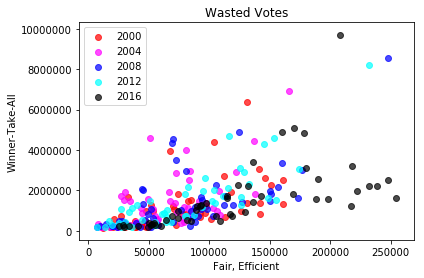

In [16]:
def plot_wasted():
    colors = {2000: 'red', 2004:'magenta', 2008:'blue', 2012:'cyan', 2016:'black'}
    plt.title('Wasted Votes')
    plt.xlabel("Fair, Efficient")
    plt.ylabel("Winner-Take-All")
    for year, data in vote_data.items():
        result_wta = wta(data)
        fe = fair_efficient(data)
        few = fe.loc[(slice(None), ['Wasted']),:].sum(axis=1)
        wtaw = result_wta.loc[(slice(None), ['Wasted']),:].sum(axis=1)
        plt.scatter(x=few, y=wtaw, color=colors[year], label=str(year), alpha=0.7)
    plt.legend()
    plt.ticklabel_format(style='plain')
plot_wasted()